<a href="https://colab.research.google.com/github/matsunagalab/lecture_ML/blob/main/machine_learning_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第4回 回帰その2：過学習と正則化


## 多項式の回帰

授業中に出てきた多項式の回帰を行います

[ 3.03594565e-01 -1.60656949e+00 -1.19809525e+01  1.69064628e+01
  8.20583403e+01 -6.64150752e+01 -2.25940054e+02  1.21630042e+02
  3.22326313e+02 -1.04797603e+02 -2.34438671e+02  3.42085681e+01
  6.86640950e+01]


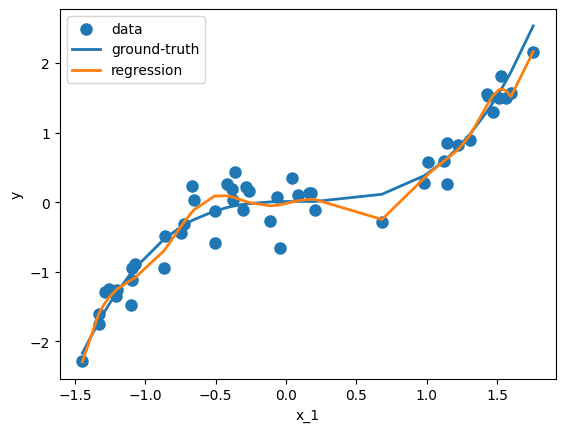

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
np.random.seed(seed=321)

# テストデータの作成
N = 50
x = 2.0 * (np.random.rand(N) - 0.5)
x = np.sort(x)
X = np.column_stack([x**i for i in range(1, 14)])
w_true = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
y = X @ w_true + 0.1 * np.random.randn(N)

# データの標準化
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 擬似逆行列を使った重回帰の計算
reg = LinearRegression(fit_intercept=False)
reg.fit(X_scaled, y_scaled)
w = reg.coef_
print(w)

# グラフの描画
plt.scatter(X_scaled[:, 0], y_scaled, label="data", marker='o', s=64)
plt.plot(X_scaled[:, 0], (X[:, 2] - scaler_X.mean_[2]) / scaler_X.scale_[2], lw=2, label="ground-truth")
plt.plot(X_scaled[:, 0], X_scaled @ w, lw=2, label="regression")
plt.xlabel("x_1")
plt.ylabel("y")
plt.legend(loc="upper left")
plt.show()

## 交差検証

交差検証を行います。K=10として様々な次数のモデルの交差検証エラーを求めます

0.170889173396334


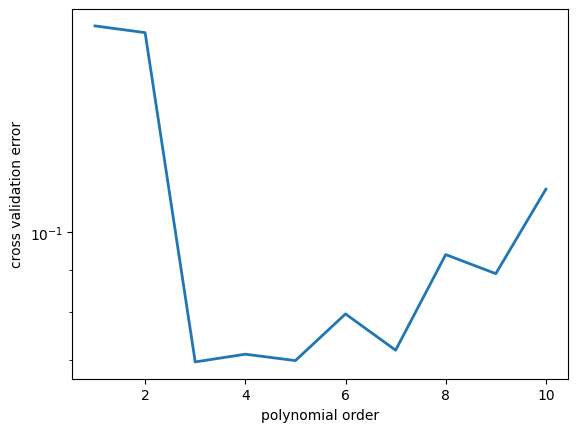

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

def compute_cross_validation_error(k, X, y, solver=LinearRegression(fit_intercept=False)):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    reg = solver
    cv_error = -cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')
    return np.mean(cv_error)

# 交差検証エラーを求める
k = 10
print(compute_cross_validation_error(k, X, y))

# 様々な次数のモデルの交差検証エラーを求める
K = 10
nth_order_max = 10
cv_error = np.zeros(nth_order_max)
for n in range(nth_order_max):
    cv_error[n] = compute_cross_validation_error(K, X_scaled[:, :(n+1)], y_scaled)

plt.plot(range(1, nth_order_max+1), cv_error, lw=2)
plt.yscale("log")
plt.xlabel("polynomial order")
plt.ylabel("cross validation error")
plt.show()


## Ridge回帰

[-0.40546466  0.02557338  1.6087629  -0.26564249  0.85268646  0.3678646
 -0.79944817  0.28183708 -1.08560435 -0.21491592 -0.29034448 -0.27902174
  1.15406269]


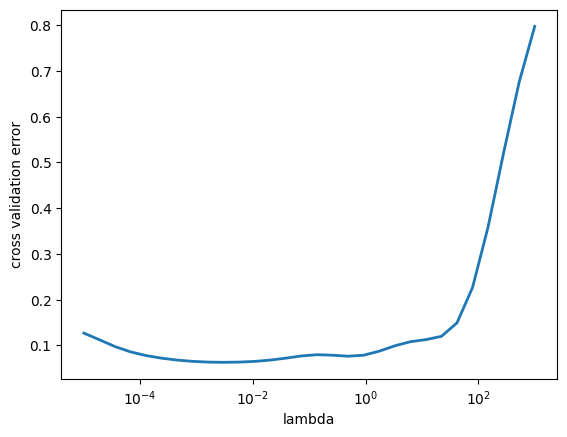

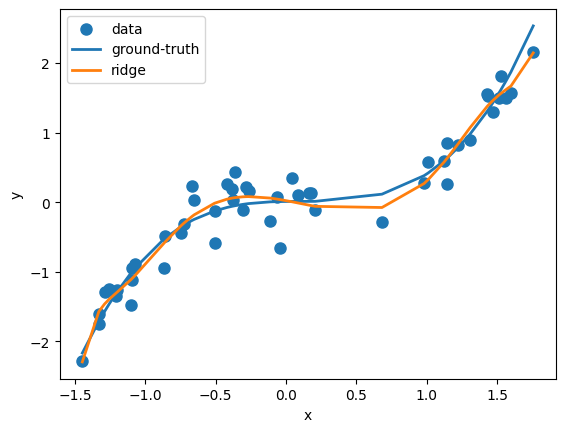

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# RidgeCVを用いて交差検証を行い最適なlambdaを求める
alphas = np.logspace(-5, 3, 30)
ridge_cv = RidgeCV(alphas=alphas, fit_intercept=False, cv=10)
ridge_cv.fit(X_scaled, y_scaled)

# 最適なlambdaのRidge回帰を求める
best_alpha = ridge_cv.alpha_
ridge_reg = Ridge(alpha=best_alpha, fit_intercept=False)
ridge_reg.fit(X_scaled, y_scaled)
print(ridge_reg.coef_)

# 交差検証エラーを求める
cv_errors = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    cv_error = -cross_val_score(ridge, X_scaled, y_scaled, cv=10, scoring='neg_mean_squared_error').mean()
    cv_errors.append(cv_error)

# Plot 1: 交差検証エラーのプロット
plt.plot(alphas, cv_errors, lw=2)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("cross validation error")
plt.show()

# Plot 2: データの散布図と、モデルの予測をラインで重ねてプロット
plt.scatter(X_scaled[:, 0], y_scaled, label="data", marker='o', s=64)
plt.plot(X_scaled[:, 0], (X[:, 2] - scaler_X.mean_[2]) / scaler_X.scale_[2], lw=2, label="ground-truth")
plt.plot(X_scaled[:, 0], X_scaled @ ridge_reg.coef_, lw=2, label="ridge")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left")
plt.show()


## Lasso回帰

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016619826411972127, tolerance: 0.0003593416355522188
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002534561717457695, tolerance: 0.0003593416355522188
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001339180555446795, tolerance: 0.0003593416355522188
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.

0.018873918221350976
[ 0.         -0.          0.95537182 -0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.02819152
 -0.        ]


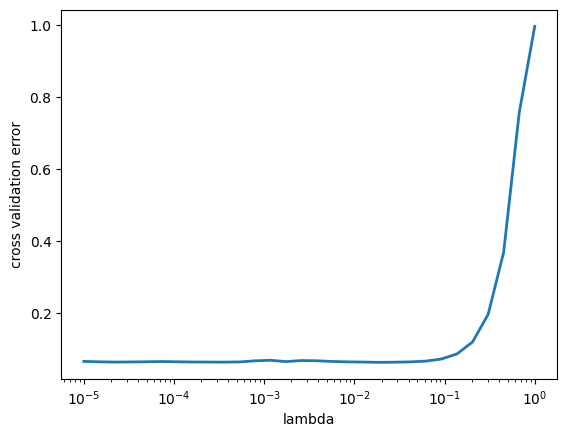

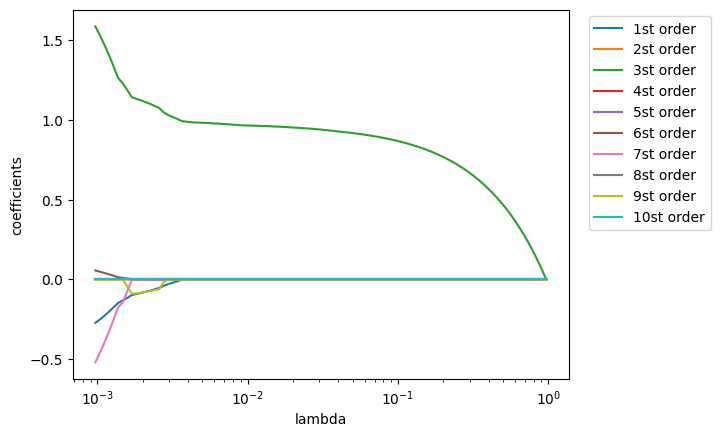

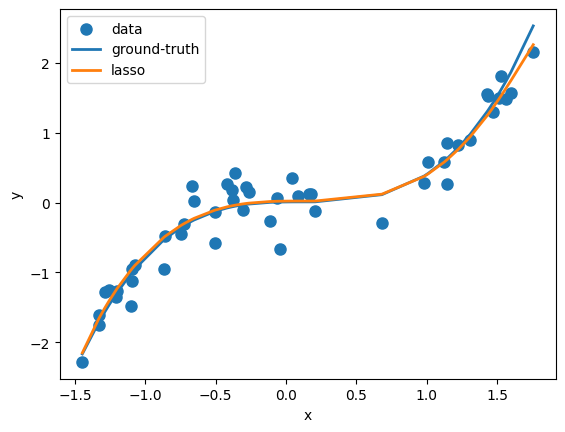

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# LassoCVを用いて交差検証を行い最適なlambdaを求める
alphas = np.logspace(-5, 0, 30)
lasso_cv = LassoCV(alphas=alphas, fit_intercept=False, max_iter=10000, tol=1e-5, cv=10, random_state=42)
lasso_cv.fit(X_scaled, y_scaled)

# 最適なlambdaのLasso回帰を求める
best_alpha = lasso_cv.alpha_
lasso_reg = Lasso(alpha=best_alpha, fit_intercept=False, max_iter=10000, tol=1e-5)
lasso_reg.fit(X_scaled, y_scaled)
print(best_alpha)
print(lasso_reg.coef_)

# Plot 1: 交差検証エラーのプロット
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), lw=2)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("cross validation error")
plt.show()

# Plot 2: 様々なalphaでのいくつかの偏回帰係数のプロット
alphas_path, coef_path, _ = lasso_cv.path(X_scaled, y_scaled)
coef_path = coef_path.T
for i in range(10):
    plt.plot(alphas_path, coef_path[:, i], label=f"{i+1}st order")
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficients")
plt.legend(loc="upper right", bbox_to_anchor=(1.30, 1))
plt.show()

# Plot 3: データの散布図と、モデルの予測をラインで重ねてプロット
plt.scatter(X_scaled[:, 0], y_scaled, label="data", marker='o', s=64)
plt.plot(X_scaled[:, 0], (X[:, 2] - scaler_X.mean_[2]) / scaler_X.scale_[2], lw=2, label="ground-truth")
plt.plot(X_scaled[:, 0], X_scaled @ lasso_reg.coef_, lw=2, label="lasso")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left")
plt.show()


## California housingへの応用

このデータセットは、米国カリフォルニア州の各ブロック地区における住宅価格データです。データセットには20640の観測値があり、説明変数(特徴量)xが8つと、目的変数yとして住宅価格が含まれています。

具体的な特徴量は以下です：
* MedInc：ブロックの中央所得
* HouseAge：ブロックの家の中央年齢
* AveRooms：世帯あたりの平均部屋数
* AveBedrms：世帯あたりの平均寝室数
* Population：ブロックの人口
* AveOccup：世帯あたりの平均家族人数
* Latitude：ブロックの緯度
* Longitude：ブロックの経度

このデータに対しLasso回帰を行って結果をプロットします。



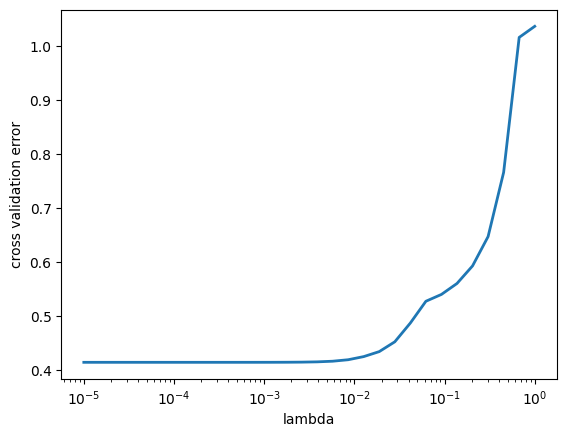

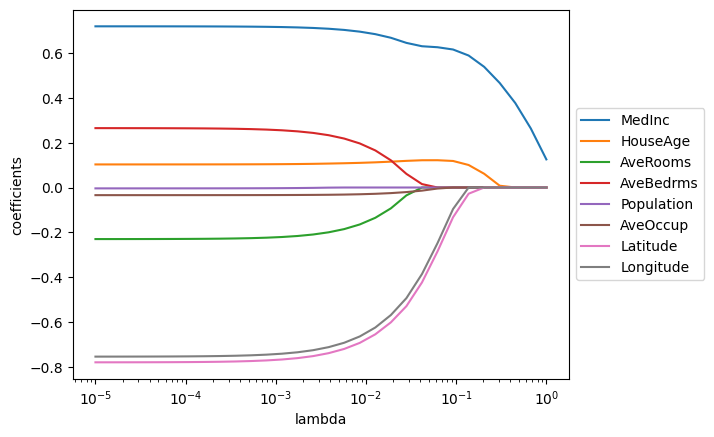

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# California housing dataを読み込む
data = fetch_california_housing()
X, y = data.data, data.target

# データを標準化する
scaler_y = StandardScaler()
scaler_X = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
X_scaled = scaler_X.fit_transform(X)

# 最適なalpha (lambda)を見つけるための交差検証
alphas = np.logspace(-5, 0, 30)
lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso_cv.fit(X_scaled, y_scaled)

# 交差検証エラーのプロット
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), lw=2)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("cross validation error")
plt.show()

# 様々なalphaでのいくつかの偏回帰係数のプロット
alphas_path, coef_path, _ = Lasso().path(X_scaled, y_scaled, alphas=alphas)
coef_path = coef_path.T
#plt.figure(figsize=(10, 6))
ax = plt.gca()
lines = ax.semilogx(alphas_path, coef_path)
plt.xlabel("lambda")
plt.ylabel("coefficients")
ax.legend(lines, data.feature_names, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()